### **We use the prtrained model (pytorch-based) for surface water mapping**


In [1]:
import config
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyrsimg import readTiff,writeTiff
from pyrsimg import imgShow
from pyrsimg import img2patch
from model import unet
from glob import glob


In [2]:
paths_scene = sorted(glob(config.dir_s2 + '/scene/*'))
paths_truth = [path_scene.replace('/scene/', '/truth/').replace('_6Bands', '').split('.')[0] + '_truth.tif' for path_scene in paths_scene]
path_img, path_truth = paths_scene[0], paths_truth[0]
path_trained_model = 'model/trained_model/unet_trained_1_weights.pth'
path_pred_save = 'wat_map.tif'


In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
torch.manual_seed(999)            #### make the trianing replicable
model = unet(num_bands=6, num_classes=2).to(device)
model.load_state_dict(torch.load(path_trained_model))


<All keys matched successfully>

In [4]:
### surface water mapping by using trained model
print('image:', path_img)
### --- 1. read in .tif image
# satellite images 
img_ins = readTiff(path_in=path_img)
truth_ins = readTiff(path_in=path_truth)

img = np.float32(np.clip(img_ins.array/10000, a_min=0, a_max=1))     ### normalization

### ---- 2. surface water mapping 
imgPat_ins = img2patch(img=img, patch_size=256, edge_overlay=100)
patch_list = imgPat_ins.toPatch()
patch_list = [torch.from_numpy(patch.transpose(2,0,1)).to(device) for patch in patch_list]  # 1.channel first and 2.numpy array to torch tensor
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]

result_patch_list = [np.squeeze(patch.detach().to(torch.device("cpu")).numpy().transpose(0,2,3,1), axis = 0) for patch in result_patch_list] ## 1.channel last and 2.torch tensor to numpy array
pro_map = imgPat_ins.toImage(result_patch_list)
pred_map = np.where(pro_map>0.5, 1, 0)
pred_map = np.int8(pred_map)

## --- 3. save the result
writeTiff(im_data=pred_map,  
            im_geotrans=img_ins.geotrans, 
            epsg_code=img_ins.epsg_code, 
            path_out=path_pred_save)

print('saved image -->:', path_pred_save)



image: /home/xin/Developer-luo/WatSet/sentinel-2/scene/S2A_L2A_20190125_N0211_R034_6Bands_S1.tif
saved image -->: wat_map.tif


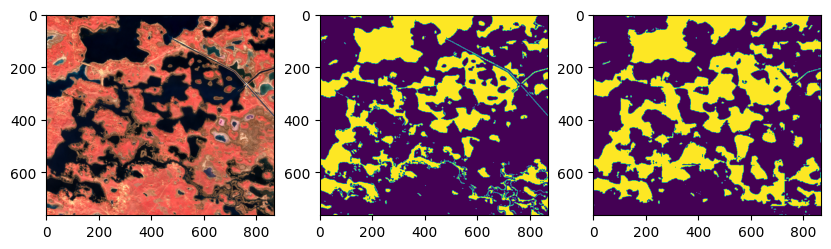

In [6]:
# ## show the image and the prediction map
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
imgShow(img, color_bands=(3,2,1), clip_percent=2)
plt.subplot(1,3,2)
imgShow(truth_ins.array, color_bands=(0,0,0), clip_percent=1)
plt.subplot(1,3,3)
imgShow(pred_map, color_bands=(0,0,0), clip_percent=1)
